# NYC Taxi dataset - anomaly detection with LSTM Autoencoder

### Libraries and settings

In [1]:
# libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, Dropout, TimeDistributed

import warnings

In [2]:
# settings
plt.rcParams['figure.figsize'] = (10,4)
sns.set()
warnings.filterwarnings('ignore')

### Dataset

```nyc_taxi.csv``` - number of NYC taxi passengers, where the five anomalies occur during the NYC marathon, Thanksgiving, Christmas, New Years Day, and a snow storm. The raw data is from the [NYC Taxi and Limousine Commission](https://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml). The data consists of aggregating the total number of taxi passengers into 30 minute buckets.

![info](https://raw.githubusercontent.com/bartk97/NYC-Taxi-Anomaly-Detection/main/Images/Data%20with%20highlighted%20anomalies.png)

### Goal
I am going to detect anomalies in the dataset.

### Import data
Importing data from https://github.com/numenta/NAB

In [3]:
# importing data
url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv'
data = pd.read_csv(url, parse_dates=['timestamp'], index_col='timestamp')
data.head()

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210
2014-07-01 01:30:00,4656
2014-07-01 02:00:00,3820


We can see that the data is split into 30 minute buckets so there are $24\cdot2 = 48$ data points per day.

In [4]:
period = 48
print(data.index[:period])

DatetimeIndex(['2014-07-01 00:00:00', '2014-07-01 00:30:00',
               '2014-07-01 01:00:00', '2014-07-01 01:30:00',
               '2014-07-01 02:00:00', '2014-07-01 02:30:00',
               '2014-07-01 03:00:00', '2014-07-01 03:30:00',
               '2014-07-01 04:00:00', '2014-07-01 04:30:00',
               '2014-07-01 05:00:00', '2014-07-01 05:30:00',
               '2014-07-01 06:00:00', '2014-07-01 06:30:00',
               '2014-07-01 07:00:00', '2014-07-01 07:30:00',
               '2014-07-01 08:00:00', '2014-07-01 08:30:00',
               '2014-07-01 09:00:00', '2014-07-01 09:30:00',
               '2014-07-01 10:00:00', '2014-07-01 10:30:00',
               '2014-07-01 11:00:00', '2014-07-01 11:30:00',
               '2014-07-01 12:00:00', '2014-07-01 12:30:00',
               '2014-07-01 13:00:00', '2014-07-01 13:30:00',
               '2014-07-01 14:00:00', '2014-07-01 14:30:00',
               '2014-07-01 15:00:00', '2014-07-01 15:30:00',
               '2014-07-

### Some information about the data

In [5]:
print('From  ' + str(np.min(data.index)) + '  to  ' +str(np.max(data.index)))

From  2014-07-01 00:00:00  to  2015-01-31 23:30:00


In [6]:
print('Data size: %d \nNumber of data per day: %d \nNumber of days: %d' %(data.shape[0], period, data.shape[0] / period))

Data size: 10320 
Number of data per day: 48 
Number of days: 215


In [7]:
print('Missing value: ', data.isnull().to_numpy().sum())

Missing value:  0


### Time Series Plot

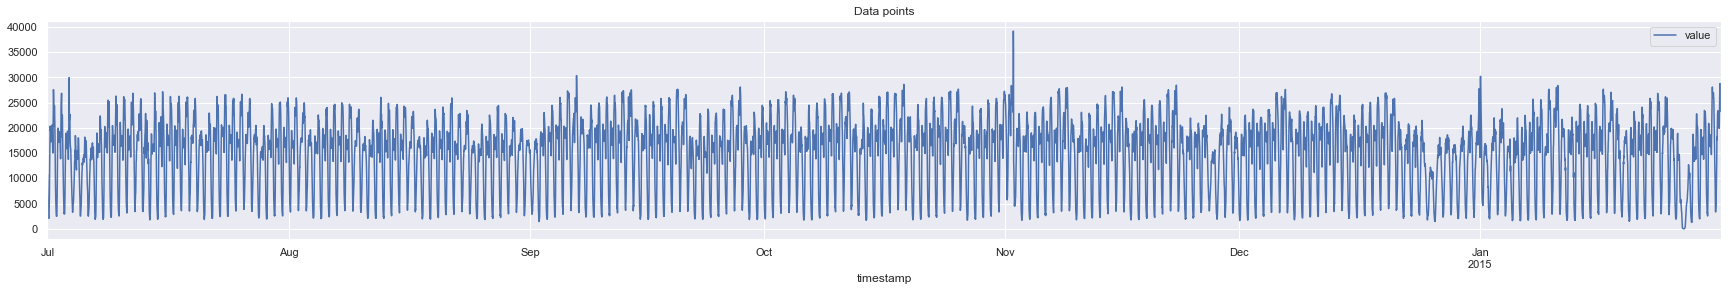

In [8]:
data.plot(title='Data points', figsize=(30,4))
plt.show()

### Plots with the data from first 5 days

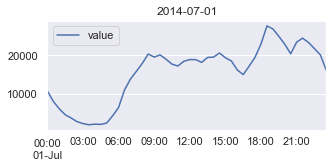

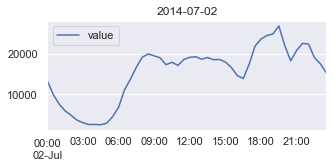

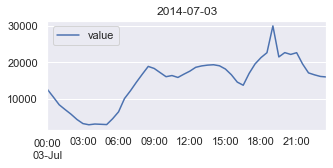

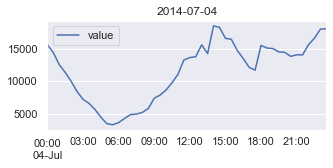

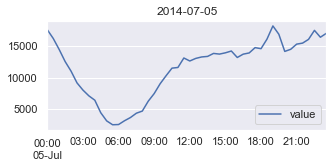

In [9]:
for i in range(5):
    data[period*i:period*(i + 1)].plot(figsize=(5, 2), title=str(data.index[period * i])[:10])
    plt.xlabel(None)
    plt.show()

### Splitting data into train and test sets

In [10]:
# splitiing
ratio = 0.55
train_size = int(data.shape[0] * ratio)
train = data[:train_size]
test = data[train_size:]

dates_train = data.index[:train_size]
dates_test = data.index[train_size:]

print('Train size: ', ratio)

print('\n\nTRAIN SET:  from  ' + str(np.min(dates_train)) + '  to  ' +str(np.max(dates_train)))
print('Data size: ', train.shape[0])
print('Number of days: ', int(train.shape[0] / period))


print('\n\nTEST SET:  from  ' + str(np.min(dates_test)) + '  to  ' +str(np.max(dates_test)))
print('Data size: ', test.shape[0])
print('Number of days: ', int(test.shape[0] / period))

Train size:  0.55


TRAIN SET:  from  2014-07-01 00:00:00  to  2014-10-27 05:30:00
Data size:  5676
Number of days:  118


TEST SET:  from  2014-10-27 06:00:00  to  2015-01-31 23:30:00
Data size:  4644
Number of days:  96


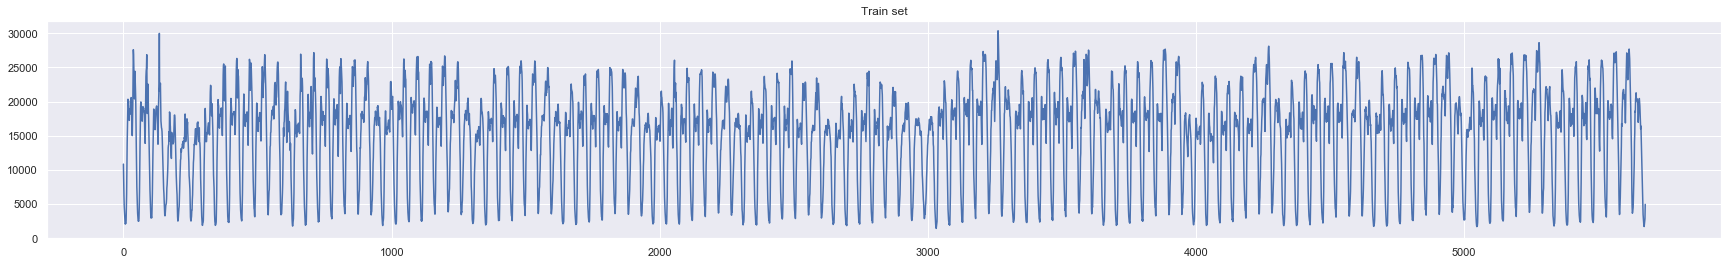

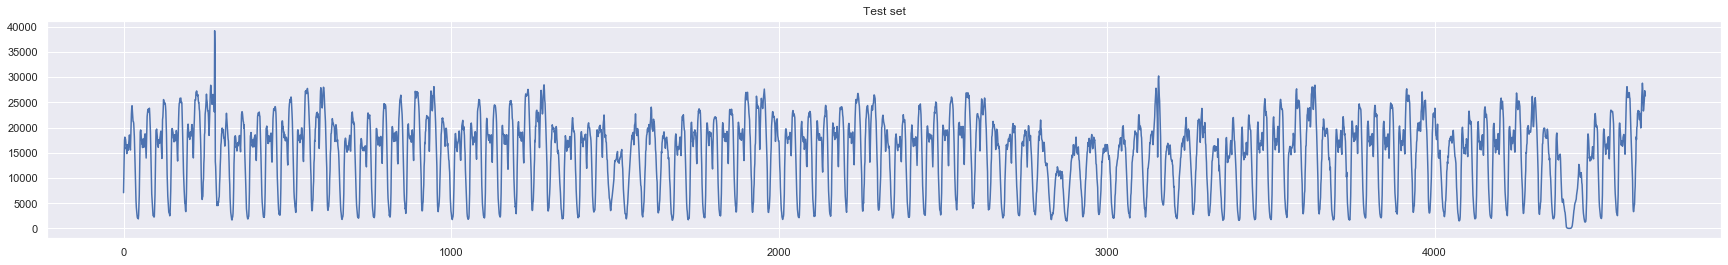

In [11]:
#plots
plt.figure(figsize=(30,4))
plt.title('Train set')
plt.plot(train.to_numpy().flatten())
plt.show()

plt.figure(figsize=(30,4))
plt.title('Test set')
plt.plot(test.to_numpy().flatten())
plt.show()

We can see that in the test set we have events such as the NYC marathon, Thanksgiving, Christmas, New Years Day, and a snow storm.

### Data standardization
Standardize data by removing the mean and scaling to unit variance.

In [12]:
scaler = StandardScaler()
scaler = scaler.fit(train.values.reshape(-1, 1))

train = scaler.transform(train.values.reshape(-1, 1))
test = scaler.transform(test.values.reshape(-1, 1))

### Splitting data into windwos

I split a time series $\{X_1, X_2, X_3, \ldots, X_T\}$ into windows $\{X_{i}, X_{i+1}, \ldots, X_{i+l}\}$ of length $l=48$.

In [13]:
def split_into_windows(X, length):
    windows = []
    for start in range(0, len(X) - length + 1):
        windows.append(X[start: start + length])
    return np.array(windows)

In [14]:
window_length = 48

X_train = split_into_windows(train, window_length)
X_test = split_into_windows(test, window_length)

_, input_length, input_dim = X_train.shape

In [15]:
X_train.shape

(5629, 48, 1)

### LSTM Autoencoder

Note: model.compile(loss='mse', optimizer='adam') - with MSE it detected anomalies on weekends because the values there are slightly higher than those on work days. It did not detect those anomalies where the values were lower than usual, e.g. Christmas, thanksgiving. Model with MAE doesn't detect weekends as an anmalia which seems better



In [16]:
# params
dim_hidden1 = 24 # 1/2 the length of one window
dim_hidden2 = 12 # 1/4 the length of one window


# model
model = Sequential()
model.add(LSTM(units=dim_hidden1, activation='relu', input_shape=(input_length, input_dim), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=dim_hidden2, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=dim_hidden2, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=dim_hidden1, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(1))

# summary
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 48, 24)            2496      
_________________________________________________________________
dropout (Dropout)            (None, 48, 24)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 48, 12)            1776      
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 12)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 48, 12)            1200      
_________________________________________________________________
dropout_2 (Dropout)          (None, 48, 12)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 48, 24)            3

### Fitting model

In [17]:
# params
batch_size = 48 # 24 hours == length of the window
epochs = 50
validation_split = 0.1
es = EarlyStopping(monitor='val_loss', patience=5)


# fitting
history = model.fit(X_train, X_train, 
                batch_size = batch_size, 
                epochs = epochs, 
                validation_split = validation_split, 
                callbacks = [es])

Train on 5066 samples, validate on 563 samples
Epoch 1/50
5066/5066 [==============================] - 36s 7ms/sample - loss: 0.6962 - val_loss: 0.4331
Epoch 2/50
5066/5066 [==============================] - 31s 6ms/sample - loss: 0.3068 - val_loss: 0.2260
Epoch 3/50
5066/5066 [==============================] - 35s 7ms/sample - loss: 0.1984 - val_loss: 0.1640
Epoch 4/50
5066/5066 [==============================] - 86s 17ms/sample - loss: 0.1479 - val_loss: 0.1299
Epoch 5/50
5066/5066 [==============================] - 81s 16ms/sample - loss: 0.1177 - val_loss: 0.1166
Epoch 6/50
5066/5066 [==============================] - 85s 17ms/sample - loss: 0.1002 - val_loss: 0.1031
Epoch 7/50
5066/5066 [==============================] - 80s 16ms/sample - loss: 0.0879 - val_loss: 0.0862
Epoch 8/50
5066/5066 [==============================] - 83s 16ms/sample - loss: 0.0791 - val_loss: 0.0831
Epoch 9/50
5066/5066 [==============================] - 69s 14ms/sample - loss: 0.0719 - val_loss: 0.0761
Ep

### Training and Validation Loss

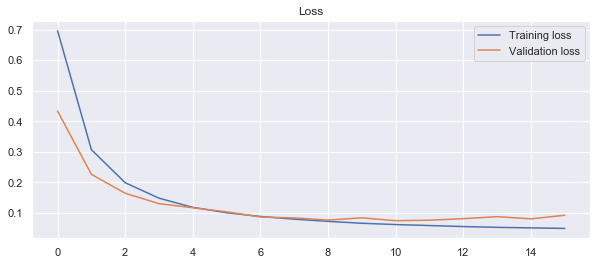

In [19]:
plt.title('Loss')
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

### Reconstruction

In [20]:
pred_x_test = model.predict(X_test)
pred_x_train = model.predict(X_train)

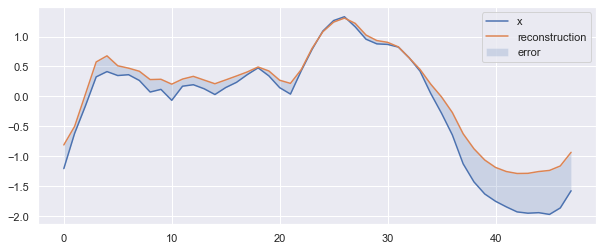

In [21]:
for i in range(int(period / window_length)):
    x = X_test[i * window_length].flatten()
    x_pred = pred_x_test[i * window_length].flatten()
    
    plt.plot(x, label='x')
    plt.plot(x_pred, label='reconstruction')
    plt.fill_between(np.arange(window_length), x, x_pred, alpha=0.2, label='error')
    plt.legend()
    plt.show()

### MSE of the reconstruction

In [22]:
mse = lambda x, x_pred: np.mean(np.abs(x - x_pred)**2, axis=1)

train_mae_loss = pd.DataFrame(mse(X_train, pred_x_train), columns=['Error'])
test_mae_loss = pd.DataFrame(mse(X_test, pred_x_test), columns=['Error'])

### Loss histrogram

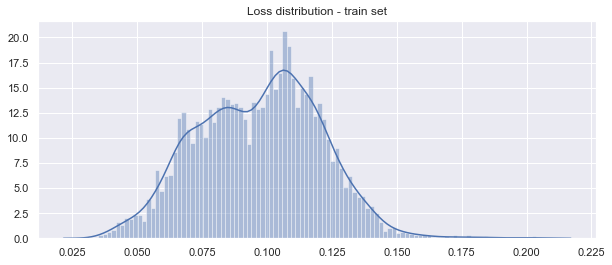

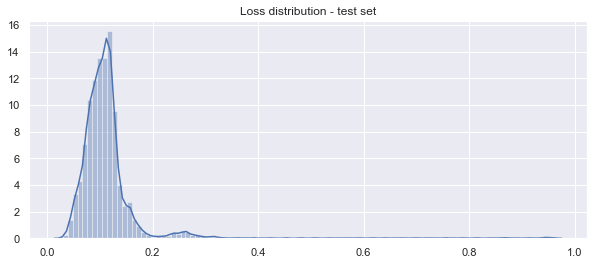

In [23]:
plt.title('Loss distribution - train set')
sns.distplot(train_mae_loss, bins=100, kde=True)
plt.show()

plt.title('Loss distribution - test set')
sns.distplot(test_mae_loss, bins=100, kde=True)
plt.show()

### Selection Threshold

threshold = mean of the loss + 2 standard devation of the loss

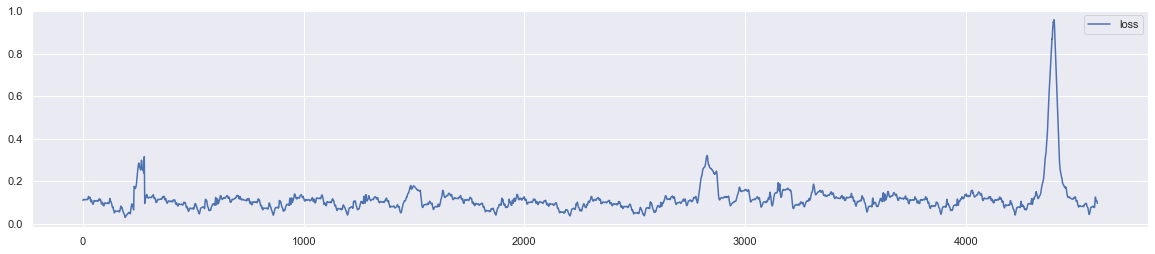

In [24]:
test_mae_loss_array = test_mae_loss.to_numpy().flatten()

plt.figure(figsize=(20,4))
plt.plot(test_mae_loss_array, label='loss')
plt.legend()
plt.show()

In [25]:
print(np.mean(test_mae_loss)[0] + 2 * np.std(test_mae_loss)[0])

0.27023699732939804


In [33]:
threshold = 0.2

### Loss for each window of the test set vs Threshold

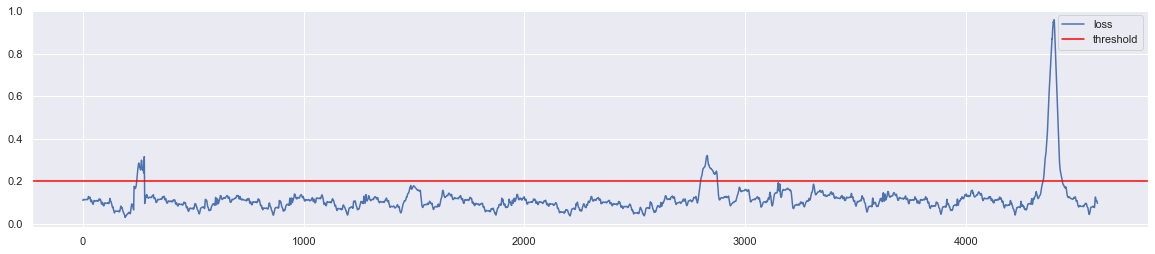

In [34]:
test_mae_loss_array = test_mae_loss.to_numpy().flatten()


plt.figure(figsize=(20,4))
plt.plot(test_mae_loss_array, label='loss')
plt.axhline(threshold, color='red', label='threshold')
plt.legend()
plt.show()

### Dates where anomalies have been detected

In [35]:
y_pred = test_mae_loss_array >= threshold
y_pred.shape

(4597,)

In [36]:
dates_test[:-(window_length-1)].shape

(4597,)

In [37]:
dates_with_hours_anomalies = dates_test[:-(window_length-1)][y_pred]

print('Dates where anomalies have been detected:')
for d in dates_with_hours_anomalies:
    print(d)

Dates where anomalies have been detected:
2014-11-01 08:00:00
2014-11-01 08:30:00
2014-11-01 09:00:00
2014-11-01 09:30:00
2014-11-01 10:00:00
2014-11-01 10:30:00
2014-11-01 11:00:00
2014-11-01 11:30:00
2014-11-01 12:00:00
2014-11-01 12:30:00
2014-11-01 13:00:00
2014-11-01 13:30:00
2014-11-01 14:00:00
2014-11-01 14:30:00
2014-11-01 15:00:00
2014-11-01 15:30:00
2014-11-01 16:00:00
2014-11-01 16:30:00
2014-11-01 17:00:00
2014-11-01 17:30:00
2014-11-01 18:00:00
2014-11-01 18:30:00
2014-11-01 19:00:00
2014-11-01 19:30:00
2014-11-01 20:00:00
2014-11-01 20:30:00
2014-11-01 21:00:00
2014-11-01 21:30:00
2014-11-01 22:00:00
2014-11-01 22:30:00
2014-11-01 23:00:00
2014-11-01 23:30:00
2014-11-02 00:00:00
2014-11-02 00:30:00
2014-11-02 01:00:00
2014-12-24 13:00:00
2014-12-24 13:30:00
2014-12-24 14:00:00
2014-12-24 14:30:00
2014-12-24 15:00:00
2014-12-24 15:30:00
2014-12-24 16:00:00
2014-12-24 16:30:00
2014-12-24 17:00:00
2014-12-24 17:30:00
2014-12-24 18:00:00
2014-12-24 18:30:00
2014-12-24 19:00:0

In [38]:
indexes = []
for d in dates_with_hours_anomalies:
    index_low = np.where(dates_test == d)
    d_temp = d  + np.timedelta64(int(window_length / 2), 'h')
    indexes.append(index_low[0][0])

### Detected anomalies - plot

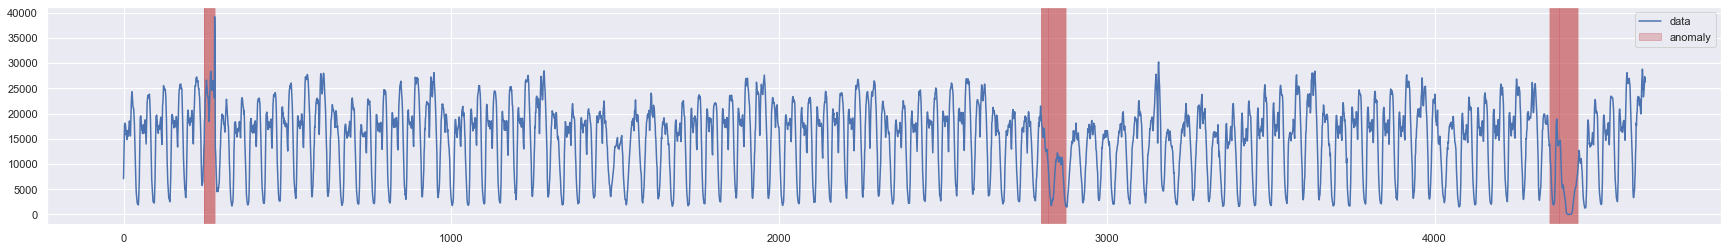

In [39]:
plt.figure(figsize=(30,4))
for index in indexes:
    plt.axvspan(index, index, color='r', alpha=0.3)
plt.plot(scaler.inverse_transform(test).flatten())
plt.legend(['data', 'anomaly'])
plt.show()

Detected anomalies  match the following events:
* [NYC Marathon](https://en.wikipedia.org/wiki/2014_New_York_City_Marathon) (02.11.2014)
* New Years Day (01.01.2015)
* [January 2015 North American blizzard](https://en.wikipedia.org/wiki/January_2015_North_American_blizzard) (26-27.01.2015)

![image info](https://raw.githubusercontent.com/bartk97/NYC-Taxi-Anomaly-Detection/main/Images/Data%20with%20highlighted%20anomalies.png)